# CIS 4567.01 Project Milestone 2
Aimee Tao, David Zhang

Objective - To make a model that can read, analyze, and compile all reviews of Amazon appliance products within the dataset

Method of Analysis - To create sentiment scores and use classification/regression to analyze it

Independent Variable - Product name, text review, star rating, etc.

Dependent Variable - The outcome categories of the review sentiment(positive or negative)

In [ ]:
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.pandas as ps
import pandas as pd

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1683830836502_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Import Appliance db from public s3 bucket in AWS
# The columns are not in order -- no have no control over this

df = spark.read.json('s3://testcis4567/cis4567_project/Appliances.json')
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|      asin|               image|overall|          reviewText| reviewTime|    reviewerID|   reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+--------------------+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|B01EM69VT8|[https://images-n...|    5.0|Worked perfectly ...| 04 7, 2017| ALZTX4Q4Y61EP|     Mela Blust|{null, null, null...|          Five Stars|    1491523200|    true|null|
|B0178HI1WQ|[https://images-n...|    5.0|I was looking for...| 08 7, 2018|A3CJOV8YCZK3RF|             jk|{ Stainless Steel...|BEST ICE MAKER WO...|    1533600000|    true|null|
|B00BRX554A|[https://images-n...|    1.0|Item not as descr...|02 28, 2017|A21PHFAQIW7FDB|        rcfreud|          

In [ ]:
# Dataset contains several columns unnessecary to us, drop those we don't need

df = df.drop('image', 'reviewTime', 'style', 'unixReviewTime', 'verified')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Shows the columns we are keeping. Kept 'asin' in order to later combine the two datasets

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+--------------------+--------------+---------------+--------------------+----+
|      asin|overall|          reviewText|    reviewerID|   reviewerName|             summary|vote|
+----------+-------+--------------------+--------------+---------------+--------------------+----+
|B01EM69VT8|    5.0|Worked perfectly ...| ALZTX4Q4Y61EP|     Mela Blust|          Five Stars|null|
|B0178HI1WQ|    5.0|I was looking for...|A3CJOV8YCZK3RF|             jk|BEST ICE MAKER WO...|null|
|B00BRX554A|    1.0|Item not as descr...|A21PHFAQIW7FDB|        rcfreud|Not as detailed a...|   5|
|B00XYVE026|    4.0|My only complaint...| A6TC1J0RY1ND4|      Kerrie S.|    Not bad, but....|  11|
|B00AUDA0GQ|    5.0|My parents refrig...|A27EO81CIR0063|Nathan Shiffler|Repaired LG LFC23...|   2|
|B00AF7U1F2|    5.0|Fits great just a...|A34ELJZYF7WA2J|    J. Bushouse|          Fits Great|null|
|B016969GWQ|    5.0|The trimer was pe...|A1N6TW5MBBKIHN|           mark|Trimer was perfec...|null|
|B01G44XXM

In [ ]:
# Import Metadata db from same public s3 bucket
# Contains detailed information of each product (name, brand, and category)

df_meta = spark.read.json('s3://testcis4567/cis4567_project/meta_Appliances.json')
df_meta.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+--------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|         brand|            category|             date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|               price|                rank|        similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------

In [ ]:
# Select the necessary columns

df_meta = df_meta.select('asin', 'brand', 'category', 'title', 'price')
df_meta.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------+--------------------+--------------------+--------------------+
|      asin|         brand|            category|               title|               price|
+----------+--------------+--------------------+--------------------+--------------------+
|7301113188|    Tupperware|[Appliances, Refr...|Tupperware Freeze...|                    |
|7861850250|    Tupperware|[Appliances, Refr...|2 X Tupperware Pu...|               $3.62|
|8792559360|The Cigar Book|[Appliances, Part...|The Cigar - Momen...|             $150.26|
|9792954481|     Caraselle|[Appliances, Part...|Caraselle 2X 50G ...|.a-box-inner{back...|
|B00002N5EL|  EATON Wiring|[Appliances, Part...|EATON Wiring 39CH...|               $3.43|
|B00002N7HY|       Leviton|[Appliances, Part...|Leviton 5050 B01-...|               $6.98|
|B00002N7IL|       Leviton|[Appliances, Part...|Leviton 5206 50 A...|                    |
|B00002N9OE|       Amerock|[Appliances, Part...|Amerock BP5322-BJ...|               $7.68|

In [ ]:
# Join the two dataframes by performing an inner join on the 'asin' column

df_join = df.join(df_meta, on = 'asin', how = 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# We can now view the two combined datasets so that the Appliances file now has the corresponding columns
df_join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+--------------------+--------------+--------------------+--------------------+----+---------------+--------------------+--------------------+-------+
|      asin|overall|          reviewText|    reviewerID|        reviewerName|             summary|vote|          brand|            category|               title|  price|
+----------+-------+--------------------+--------------+--------------------+--------------------+----+---------------+--------------------+--------------------+-------+
|B013M85X1W|    3.0|Doesn't come with...| AIPIC5X32C8V1|          Eaking8714|       A Good Value.|   2|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00UI24740|    5.0|I love this. I bo...|A11I8A2FLLPH03|Da&#039;Tiana Galvan|Best I've had in ...|null|     Frigidaire|[Appliances, Laun...|Frigidaire FFLE40...|       |
|B013M85X1W|    5.0|This hood looks g...|A3UNHU9NO9IHU7|                Nope|High end look at ...|null|           AKDY|[Appliances, Rang...|AKDY 30&qu

In [ ]:
df_join = df_join.select('asin', 'overall', 'reviewText', 'reviewerID', 'reviewerName', 'brand', 'category', 'title', 'price')
df_join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|      asin|overall|          reviewText|    reviewerID|        reviewerName|          brand|            category|               title|  price|
+----------+-------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|B013M85X1W|    3.0|Doesn't come with...| AIPIC5X32C8V1|          Eaking8714|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00UI24740|    5.0|I love this. I bo...|A11I8A2FLLPH03|Da&#039;Tiana Galvan|     Frigidaire|[Appliances, Laun...|Frigidaire FFLE40...|       |
|B013M85X1W|    5.0|This hood looks g...|A3UNHU9NO9IHU7|                Nope|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00JYLTZ6Q|    5.0|This is the 43920...|A28NBTRSWMGY21|          The Prybar|      Whirlpool|[Appliances, Part...|4392065 New Oem F...| 

In [ ]:
# Rename columns

df_join = df_join.withColumnRenamed('overall', 'rating')\
.withColumnRenamed('reviewText', 'review')\
.withColumnRenamed('reviewerID', 'customer_ID')\
.withColumnRenamed('reviewerName', 'customer_name')\
.withColumnRenamed('title', 'product_name')

df_join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|      asin|rating|              review|   customer_ID|       customer_name|          brand|            category|        product_name|  price|
+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|B013M85X1W|   3.0|Doesn't come with...| AIPIC5X32C8V1|          Eaking8714|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00UI24740|   5.0|I love this. I bo...|A11I8A2FLLPH03|Da&#039;Tiana Galvan|     Frigidaire|[Appliances, Laun...|Frigidaire FFLE40...|       |
|B013M85X1W|   5.0|This hood looks g...|A3UNHU9NO9IHU7|                Nope|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00JYLTZ6Q|   5.0|This is the 43920...|A28NBTRSWMGY21|          The Prybar|      Whirlpool|[Appliances, Part...|4392065 New Oem F...| $24.93|

In [ ]:
# Double check for dup
# Create dup indicator and ran it for each review
# If it exists, dup indictor will return true. Else, return false

df_join.join(df_join.groupBy(df_join.columns).agg((F.count('*') > 1).cast('string').alias('Duplicate_indicator')),
                       on = df_join.columns, how = 'inner')
df_join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|      asin|rating|              review|   customer_ID|       customer_name|          brand|            category|        product_name|  price|
+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|B013M85X1W|   3.0|Doesn't come with...| AIPIC5X32C8V1|          Eaking8714|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00UI24740|   5.0|I love this. I bo...|A11I8A2FLLPH03|Da&#039;Tiana Galvan|     Frigidaire|[Appliances, Laun...|Frigidaire FFLE40...|       |
|B013M85X1W|   5.0|This hood looks g...|A3UNHU9NO9IHU7|                Nope|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00JYLTZ6Q|   5.0|This is the 43920...|A28NBTRSWMGY21|          The Prybar|      Whirlpool|[Appliances, Part...|4392065 New Oem F...| $24.93|

In [ ]:
# Drop any duplicates

df_join = df_join.dropDuplicates()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Drop the null values, only want reviews that contain written feedback.

df_join = df_join.na.drop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Check if any null values remaining after dropping, find that there are none

df_join.where(col('review').isNull()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+------+-----------+-------------+-----+--------+------------+-----+
|asin|rating|review|customer_ID|customer_name|brand|category|product_name|price|
+----+------+------+-----------+-------------+-----+--------+------------+-----+
+----+------+------+-----------+-------------+-----+--------+------------+-----+

In [ ]:
# Convert rating to int

df_join = df_join.withColumn('rating', col('rating').cast('int'))
df_join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|      asin|rating|              review|   customer_ID|       customer_name|          brand|            category|        product_name|  price|
+----------+------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+-------+
|B013M85X1W|     3|Doesn't come with...| AIPIC5X32C8V1|          Eaking8714|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00UI24740|     5|I love this. I bo...|A11I8A2FLLPH03|Da&#039;Tiana Galvan|     Frigidaire|[Appliances, Laun...|Frigidaire FFLE40...|       |
|B013M85X1W|     5|This hood looks g...|A3UNHU9NO9IHU7|                Nope|           AKDY|[Appliances, Rang...|AKDY 30&quot; Wal...| $16.32|
|B00JYLTZ6Q|     5|This is the 43920...|A28NBTRSWMGY21|          The Prybar|      Whirlpool|[Appliances, Part...|4392065 New Oem F...| $24.93|

In [ ]:
# Was having issues sorting count by category, need to change the column to string

df_join.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- asin: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- customer_ID: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- product_name: string (nullable = true)
 |-- price: string (nullable = true)

In [ ]:
# Changed from array to string in order to sort by most popular appliance with a word count

df_join = df_join.withColumn("category", concat_ws(", ", "category"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Want to narrow appliances down to one specific category, looking for a popular item
# Split the words to count each seperately, explode to create row for each, and count

df_split = df_join.select(split(df_join.category, ",\s*").alias("category"))

df_explode = df_split.select(explode(df_split.category).alias("category"))

df_count = df_explode.groupBy("category").count().orderBy("count", ascending=False)
df_count.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|            category| count|
+--------------------+------+
|          Appliances|581103|
| Parts & Accessories|487767|
|Refrigerator Part...|192325|
|       Water Filters|127114|
|Dryer Parts & Acc...| 65393|
|Washer Parts & Ac...| 49518|
|   Replacement Parts| 43088|
|Range Parts & Acc...| 38432|
|       Refrigerators| 38369|
|Humidifier Parts ...| 36747|
+--------------------+------+
only showing top 10 rows

In [ ]:
# Filter the data so it only contains products related to water filters

df_sorted = df_join.filter(array_contains(split(df_join.category, ", "), "Water Filters"))
df_sorted.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+------+
|      asin|rating|              review|   customer_ID|    customer_name|          brand|            category|        product_name| price|
+----------+------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+------+
|B00YD2VC8K|     1|Unfortunately, th...| AAN2Z0FPWYHH5|     Stephanie L.|UpStart Battery|Appliances, Parts...|2-Pack Replacemen...|$24.99|
|B00YD2VC8K|     1|Doesn't actually ...|A2CVI72BWRTQE1|       Green Mama|UpStart Battery|Appliances, Parts...|2-Pack Replacemen...|$24.99|
|B00J4MTGGE|     5|Looks awesome, on...|A1V8TTHX9NGEV6|           Conner|       ICEDADDY|Appliances, Parts...|ICEDADDY Refriger...| $0.91|
|B00J4MTGGE|     2|These say compati...|A3G9WZEOJIW6EF|              Raz|       ICEDADDY|Appliances, Parts...|ICEDADDY Refriger...| $0.91|
|B016NCT8DI|     2|Made my 

# Text Cleaning


In [ ]:
# Import necessary libraries and resources

import pandas as pd
import pyspark.pandas as ps
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import concat_ws, col, lit   #for converting array<string> to string

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Lowercase the text data and remove any non-alphabetic characters. Create a new column 'review_text' with the cleaned text data
# Keep asin column so we can join the df back

df_clean = df_sorted.select('customer_ID', 'review', (lower(regexp_replace('review', '[^a-zA-Z\\s]', '')).alias('review_text')))
df_clean.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+--------------------+
|   customer_ID|              review|         review_text|
+--------------+--------------------+--------------------+
| AAN2Z0FPWYHH5|Unfortunately, th...|unfortunately the...|
|A2CVI72BWRTQE1|Doesn't actually ...|doesnt actually w...|
|A1V8TTHX9NGEV6|Looks awesome, on...|looks awesome onl...|
|A3G9WZEOJIW6EF|These say compati...|these say compati...|
|A1PAMUKF5TB9QX|Made my ice cubes...|made my ice cubes...|
|A2Y0ZQKTHO8DYV|The quality of th...|the quality of th...|
|A1FA58KTDMFZC0|Really one side o...|really one side o...|
|A11WE34OOZ8QN8|Thought this woul...|thought this woul...|
| AYU9KZJC44WBT|The patch was mad...|the patch was mad...|
|A2B77BIQAU78UG|Filters fit the A...|filters fit the a...|
|A3FG5QC85QGC77|Made the water ta...|made the water ta...|
|A2RNEM77P16VQ9|Water does not ta...|water does not ta...|
|A2UJ20PPDQ4BN8|Fast flow, size i...|fast flow size is...|
| A4GYFAFMTQ0UT|Probably one of t...|probably one of t..

In [ ]:
# Tokenize the cleaned text

tokenizer = Tokenizer(inputCol = 'review_text', outputCol = 'words_token')
df_words_token = tokenizer.transform(df_clean).select('customer_ID', 'review_text', 'words_token')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Remove stopwords from the tokenized words

remover = StopWordsRemover(inputCol = 'words_token', outputCol = 'words_clean')
no_stop_word = remover.transform(df_words_token).select('customer_ID', 'review_text', 'words_clean')
no_stop_word.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+--------------------+
|   customer_ID|         review_text|         words_clean|
+--------------+--------------------+--------------------+
| AAN2Z0FPWYHH5|unfortunately the...|[unfortunately, d...|
|A2CVI72BWRTQE1|doesnt actually w...|[doesnt, actually...|
|A1V8TTHX9NGEV6|looks awesome onl...|[looks, awesome, ...|
|A3G9WZEOJIW6EF|these say compati...|[say, compatible,...|
|A1PAMUKF5TB9QX|made my ice cubes...|[made, ice, cubes...|
|A2Y0ZQKTHO8DYV|the quality of th...|[quality, patch, ...|
|A1FA58KTDMFZC0|really one side o...|[really, one, sid...|
|A11WE34OOZ8QN8|thought this woul...|[thought, bigger,...|
| AYU9KZJC44WBT|the patch was mad...|[patch, made, mul...|
|A2B77BIQAU78UG|filters fit the a...|[filters, fit, se...|
|A3FG5QC85QGC77|made the water ta...|[made, water, tas...|
|A2RNEM77P16VQ9|water does not ta...|[water, taste, go...|
|A2UJ20PPDQ4BN8|fast flow size is...|[fast, flow, size...|
| A4GYFAFMTQ0UT|probably one of t...|[probably, one, w..

In [ ]:
# Lemmatize reviews, apply UDF on `words_clean` column

stemmer = SnowballStemmer(language = 'english')

def stem_words(words):
    return [stemmer.stem(word) for word in words]

stem_udf = udf(stem_words, ArrayType(StringType()))
df_stemmed = no_stop_word.withColumn('words_stemmed', stem_udf('words_clean'))
df_stemmed.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+--------------------+--------------------+
|   customer_ID|         review_text|         words_clean|       words_stemmed|
+--------------+--------------------+--------------------+--------------------+
| AAN2Z0FPWYHH5|unfortunately the...|[unfortunately, d...|[unfortun, didnt,...|
|A2CVI72BWRTQE1|doesnt actually w...|[doesnt, actually...|[doesnt, actual, ...|
|A1V8TTHX9NGEV6|looks awesome onl...|[looks, awesome, ...|[look, awesom, lo...|
|A3G9WZEOJIW6EF|these say compati...|[say, compatible,...|[say, compat, hoo...|
|A1PAMUKF5TB9QX|made my ice cubes...|[made, ice, cubes...|[made, ice, cube,...|
|A2Y0ZQKTHO8DYV|the quality of th...|[quality, patch, ...|[qualiti, patch, ...|
|A1FA58KTDMFZC0|really one side o...|[really, one, sid...|[realli, one, sid...|
|A11WE34OOZ8QN8|thought this woul...|[thought, bigger,...|[thought, bigger,...|
| AYU9KZJC44WBT|the patch was mad...|[patch, made, mul...|[patch, made, mul...|
|A2B77BIQAU78UG|filters fit the a...|[fi

In [ ]:
# Change reviews column back into a string

df_good = df_stemmed.withColumn('reviews', concat_ws(' ', 'words_clean'))
df_good.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+--------------------+--------------------+--------------------+
|   customer_ID|         review_text|         words_clean|       words_stemmed|             reviews|
+--------------+--------------------+--------------------+--------------------+--------------------+
| AAN2Z0FPWYHH5|unfortunately the...|[unfortunately, d...|[unfortun, didnt,...|unfortunately did...|
|A2CVI72BWRTQE1|doesnt actually w...|[doesnt, actually...|[doesnt, actual, ...|doesnt actually w...|
|A1V8TTHX9NGEV6|looks awesome onl...|[looks, awesome, ...|[look, awesom, lo...|looks awesome loo...|
|A3G9WZEOJIW6EF|these say compati...|[say, compatible,...|[say, compat, hoo...|say compatible ho...|
|A1PAMUKF5TB9QX|made my ice cubes...|[made, ice, cubes...|[made, ice, cube,...|made ice cubes bl...|
|A2Y0ZQKTHO8DYV|the quality of th...|[quality, patch, ...|[qualiti, patch, ...|quality patch goo...|
|A1FA58KTDMFZC0|really one side o...|[really, one, sid...|[realli, one, sid...|really one s

In [ ]:
# Only need to keep the cleaned 'words' category

df_finish = df_good.select(['customer_ID', 'reviews'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Join our 'df_sorted' and 'df_finish' together

df_sorted = df_sorted.drop('review')
df_final = df_sorted.join(df_finish.select('customer_ID', 'reviews'), on = 'customer_ID', how ='inner')
df_final.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+------+---------------+--------------------+--------------------+--------------------+-------+--------------------+
|         customer_ID|      asin|rating|  customer_name|               brand|            category|        product_name|  price|             reviews|
+--------------------+----------+------+---------------+--------------------+--------------------+--------------------+-------+--------------------+
|A01704365WXWXHQIZMHJ|B00HT39KCU|     5|Amazon Customer|               Tier1|Appliances, Parts...|Tier1 Replacement...| $10.44|filters work perf...|
|A0877179R3O0A41LGAGM|B00ZY6KM4E|     1|       Jackie G|             ICEPURE|Appliances, Parts...|ICEPURE DA29-0002...| $29.99|put filter fridge...|
|      A101CDY0ZO1WPI|B00E37TR6E|     5|    Barb Thomas|             EcoAqua|Appliances, Parts...|EcoAqua EFF-6013A...| $15.59|product works per...|
|       A101HUYQ0IP1M|B00UXG4WR8|     3|Amazon Customer|EveryDrop by Whir...|Appliances, Parts...|EveryDro

# Counting Top Reviewed Products

In [ ]:
# Counting the total amount of reviews per water filter product

asin_count = df_sorted.groupBy('asin', 'product_name').count().sort(desc('count'))
asin_count = asin_count.withColumnRenamed('count', 'review_count')
asin_count.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+------------+
|      asin|        product_name|review_count|
+----------+--------------------+------------+
|B000AST3AK|General Electric ...|        6509|
|B004UB1O9Q|Samsung Genuine D...|        5698|
|B00KJ07SEM|GE MWF SmartWater...|        3199|
|B0045LLC7K|Frigidaire WF3CB ...|        2933|
|B00E37TQV0|EcoAqua DA29-0002...|        2314|
|B0042ACZU2|LG LT700P Refrige...|        2032|
|B00AHR3IG4|Samsung Genuine D...|        1699|
|B009PCI2JU|GE RPWFE Refriger...|        1444|
|B00UXG4WR8|EveryDrop by Whir...|        1403|
|B01CC7O8JW|Waterdrop MWF Ref...|        1279|
+----------+--------------------+------------+
only showing top 10 rows

In [ ]:
# Counting the total amount of brands per water filter product

brand_count = df_sorted.groupBy('brand').count().sort(desc('count'))
brand_count = brand_count.withColumnRenamed('count', 'brand_count')
brand_count.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|               brand|brand_count|
+--------------------+-----------+
|           Waterdrop|      15178|
|             EcoAqua|      11043|
|                  GE|       9867|
|             Samsung|       8685|
|    Waterfall Filter|       6284|
|EveryDrop by Whir...|       5778|
|             Refresh|       5580|
|             ICEPURE|       5574|
|               Tier1|       5439|
|       WaterSentinel|       5426|
+--------------------+-----------+
only showing top 10 rows

In [ ]:
# Create a function that returns the rating counts for each product to use

def get_rating_counts(df_sorted, asin):
    rating_counts = df_sorted.filter(col('asin') == asin).groupBy('rating').agg(count('*').alias('count')).orderBy('rating', ascending = False)
    return rating_counts

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# 1 - Counting the total amount of ratings for the first top appliance item: asin = 'B000AST3AK'

asin_1 = 'B000AST3AK'
rating_1 = get_rating_counts(df_sorted, asin_1)
rating_1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5| 4665|
|     4|  960|
|     3|  292|
|     2|  152|
|     1|  440|
+------+-----+

In [ ]:
# 2 - Counting the total amount of ratings for the second top appliance item: asin = 'B004UB1O9Q'

asin_2 = 'B004UB1O9Q'
rating_2 = get_rating_counts(df_sorted, asin_2)
rating_2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5| 4048|
|     4|  769|
|     3|  201|
|     2|  139|
|     1|  541|
+------+-----+

In [ ]:
# 3 - Counting the total amount of ratings for the third top appliance item: asin = 'B00KJ07SEM'

asin_3 = 'B00KJ07SEM'
rating_3 = get_rating_counts(df_sorted, asin_3)
rating_3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5| 2408|
|     4|  344|
|     3|   77|
|     2|   88|
|     1|  282|
+------+-----+

In [ ]:
# 4 - Counting the total amount of ratings for the fourth top appliance item: asin = 'B0045LLC7K'

asin_4 = 'B0045LLC7K'
rating_4 = get_rating_counts(df_sorted, asin_4)
rating_4.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5| 2133|
|     4|  373|
|     3|  129|
|     2|   71|
|     1|  227|
+------+-----+

In [ ]:
# 5 - Counting the total amount of ratings for the fifth top appliance item: asin = 'B00E37TQV0'

asin_5 = 'B00E37TQV0'
rating_5 = get_rating_counts(df_sorted, asin_5)
rating_5.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5| 1701|
|     4|  276|
|     3|   66|
|     2|   60|
|     1|  211|
+------+-----+

In [ ]:
# TOTAL - Counting the total amount of ratings per star

rating_count = df_sorted.groupBy('rating').count().sort(desc('count'))
rating_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|rating|count|
+------+-----+
|     5|91645|
|     4|15074|
|     1|12769|
|     3| 4285|
|     2| 3341|
+------+-----+

In [ ]:
count_df = df_final.withColumn('word', F.explode(F.split(F.col('reviews'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending = False)

count_df.show(50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|        word| count|
+------------+------+
|            |124415|
|      filter| 72982|
|       water| 64847|
|       great| 41416|
|       price| 28831|
|       works| 27276|
|     filters| 25789|
|        good| 25650|
|     product| 21961|
|         one| 19880|
|         fit| 18040|
|refrigerator| 16253|
|      fridge| 14642|
|        well| 14148|
|       taste| 13326|
|        easy| 12361|
|     samsung| 12180|
|       brand| 11869|
|        like| 11868|
|        time| 11661|
|        work| 11643|
| replacement| 11632|
|          ge| 11146|
|         buy| 11066|
|        much| 10114|
|     install| 10098|
|     perfect|  9739|
|   perfectly|  9648|
|        fine|  9268|
|      tastes|  8691|
|    original|  8315|
|        fits|  7978|
|      better|  7607|
|      months|  7246|
|   installed|  7083|
|      worked|  6808|
|         get|  6770|
|         oem|  6641|
|      bought|  6387|
|   expensive|  6336|
|         new|  6197|
|     cheaper|  6163|
|       fi

# Data Visualizations

In [ ]:
# Importing necessary resources

import matplotlib.pyplot as plt
import pyspark.pandas as ps
ps.set_option('plotting.backend', 'matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

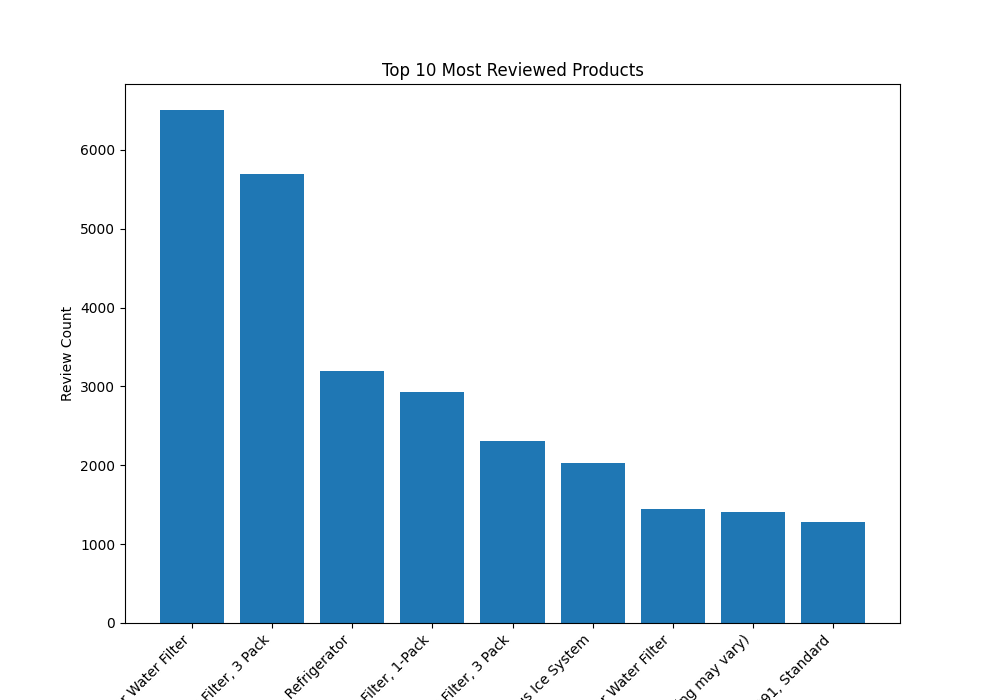

In [ ]:
# Generate a bar chart of the top 10 most reviewed products within our appliance dataset based on thier 'asin'

plt.clf()
top_prod = asin_count.toPandas()

fig, ax = plt.subplots(figsize = (10, 7))
plt.bar(top_prod['product_name'][:10], top_prod['review_count'][:10])
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Product Name')
plt.ylabel('Review Count')
plt.title('Top 10 Most Reviewed Products')


%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

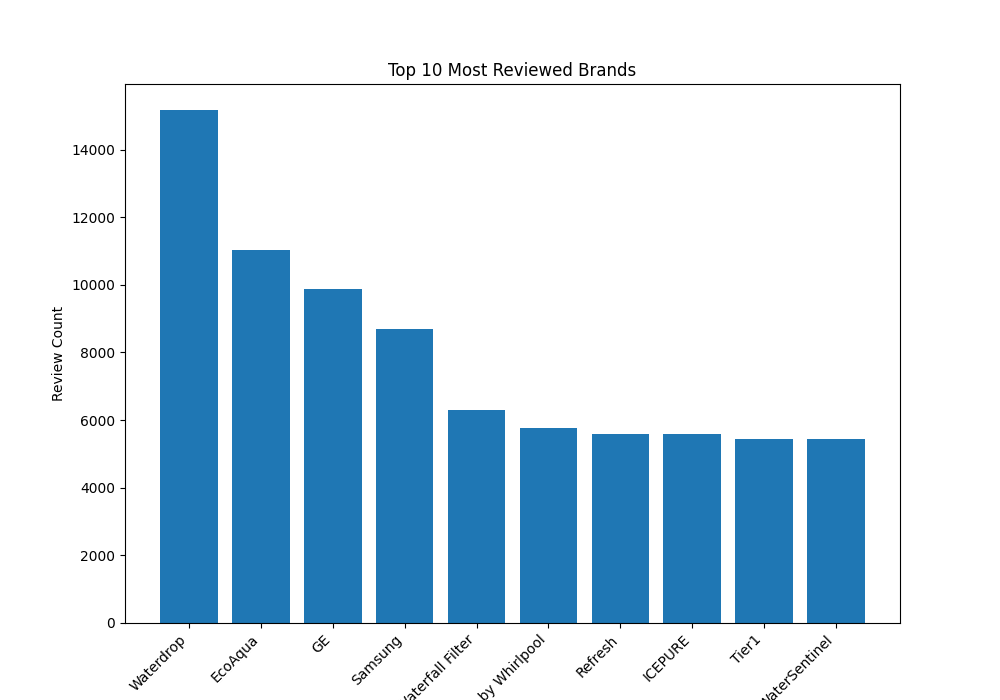

In [ ]:
# Bar chart of the top 10 brands

plt.clf()
top_prod = brand_count.toPandas()

fig, ax = plt.subplots(figsize = (10, 7))
plt.bar(top_prod['brand'][:10], top_prod['brand_count'][:10])
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Brand')
plt.ylabel('Review Count')
plt.title('Top 10 Most Reviewed Brands')


%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

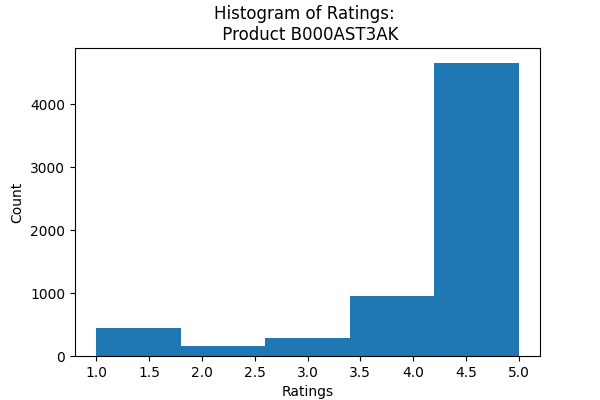

In [ ]:
# Create a histogram of the first rating's category with 5 bins for each star rating. People with 2 and 3 star ratings are less than those who gave the product a bad 1-star review.

plt.clf()

ratings_1 = rating_1.select('rating').rdd.flatMap(lambda x: x).collect()
counts_1 = rating_1.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize = (6,4))
plt.hist(ratings_1, bins = 5, weights = counts_1)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Histogram of Ratings: \n Product B000AST3AK')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

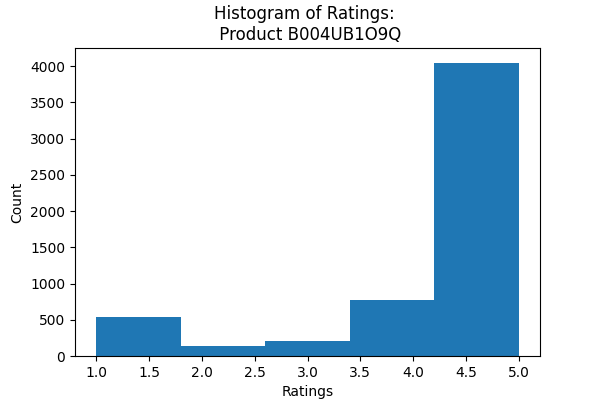

In [ ]:
# Create a histogram of the second rating's category. Similar to product B000AST3AK above, over 500 people gave it a 1-star review. We can analyze the reviews for this product to find out why

plt.clf()

ratings_2 = rating_2.select('rating').rdd.flatMap(lambda x: x).collect()
counts_2 = rating_2.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize = (6,4))
plt.hist(ratings_2, bins = 5, weights = counts_2)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Histogram of Ratings: \n Product B004UB1O9Q')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

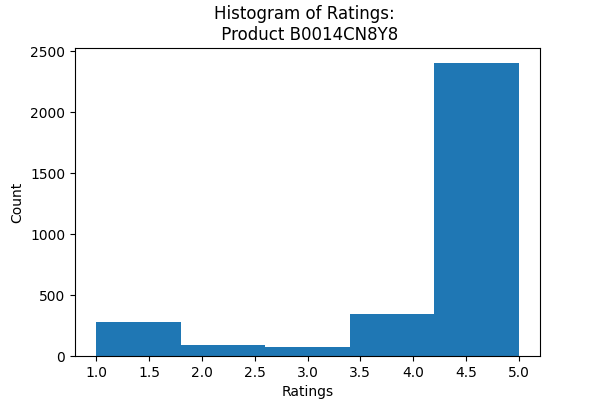

In [ ]:
# Create a histogram of the third rating's category. This product has the best reviews so far, considering they have less than 100 1-star ratings!

plt.clf()

ratings_3 = rating_3.select('rating').rdd.flatMap(lambda x: x).collect()
counts_3 = rating_3.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize = (6,4))
plt.hist(ratings_3, bins = 5, weights = counts_3)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Histogram of Ratings: \n Product B0014CN8Y8')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

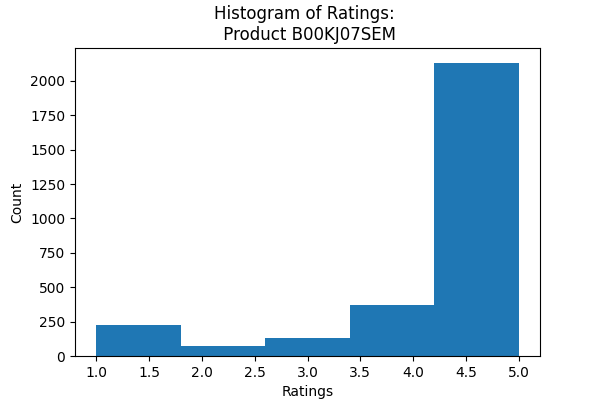

In [ ]:
# Create a histogram of the fourth rating's category. While most customers found this product more than satisfactory, some still were not happy.

plt.clf()

ratings_4 = rating_4.select('rating').rdd.flatMap(lambda x: x).collect()
counts_4 = rating_4.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize = (6,4))
plt.hist(ratings_4, bins = 5, weights = counts_4)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Histogram of Ratings: \n Product B00KJ07SEM')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

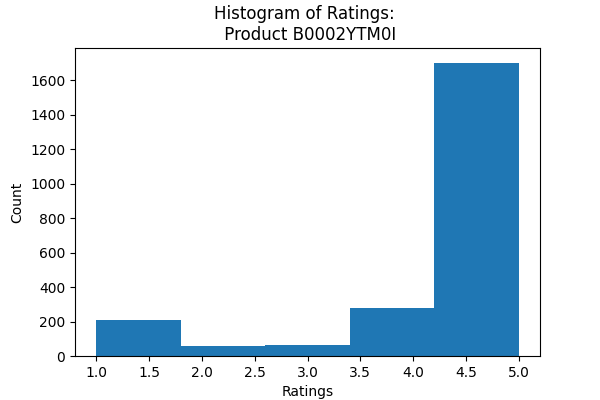

In [ ]:
# Create a histogram of the fifth rating's category. This distribution is a good sign, most customers were happy with product B0002YTM0I

plt.clf()

ratings_5 = rating_5.select('rating').rdd.flatMap(lambda x: x).collect()
counts_5 = rating_5.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize = (6,4))
plt.hist(ratings_5, bins = 5, weights = counts_5)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Histogram of Ratings: \n Product B0002YTM0I')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

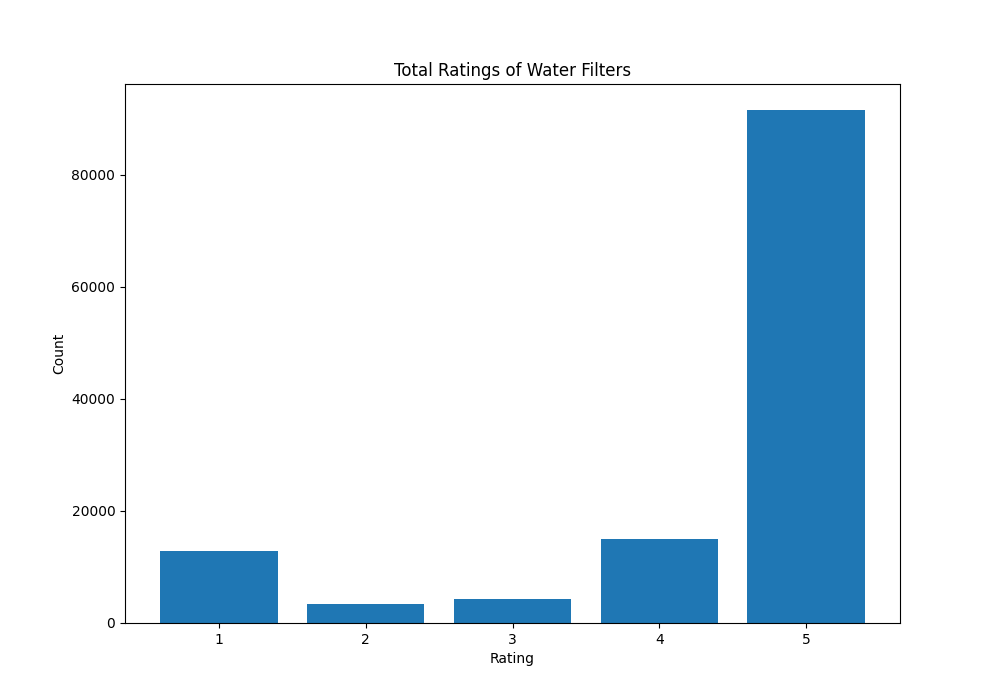

In [ ]:
# Creating a bar chart of the ratings category. We see that overall, a majority of the products get a 5 star review!

plt.clf()
rating_count_pd = rating_count.toPandas()

plt.bar(rating_count_pd["rating"], rating_count_pd["count"])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Total Ratings of Water Filters")

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

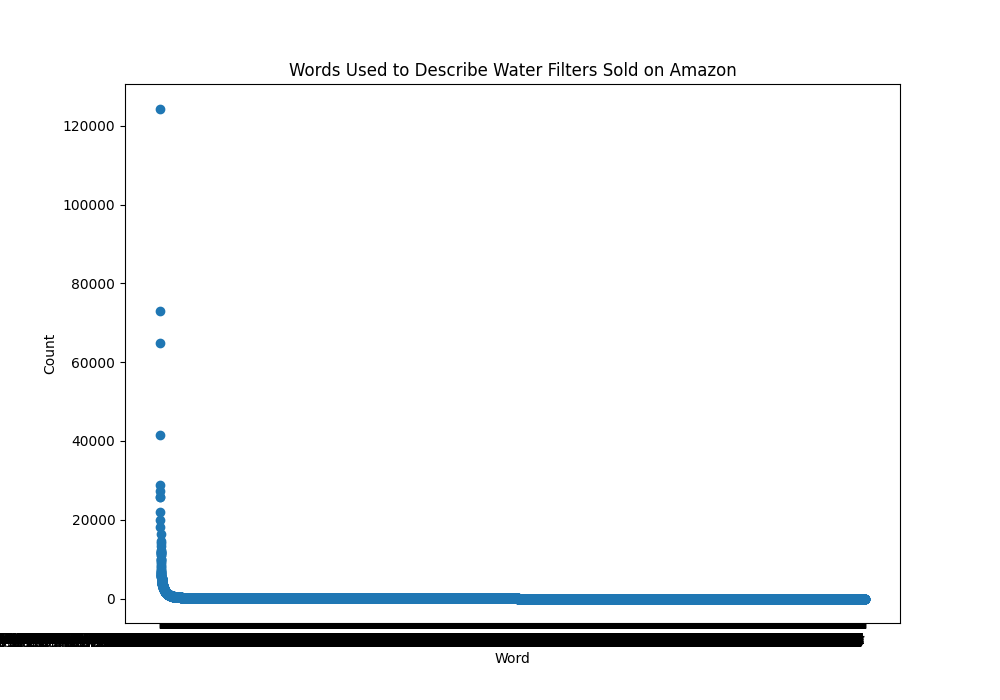

In [ ]:
# Create a scatter plot of the words used in the dataset

plt.clf()
plot_words = count_df.toPandas()

plt.scatter(plot_words['word'], plot_words['count'])
plt.xticks(ha = 'right')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Words Used to Describe Water Filters Sold on Amazon')

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

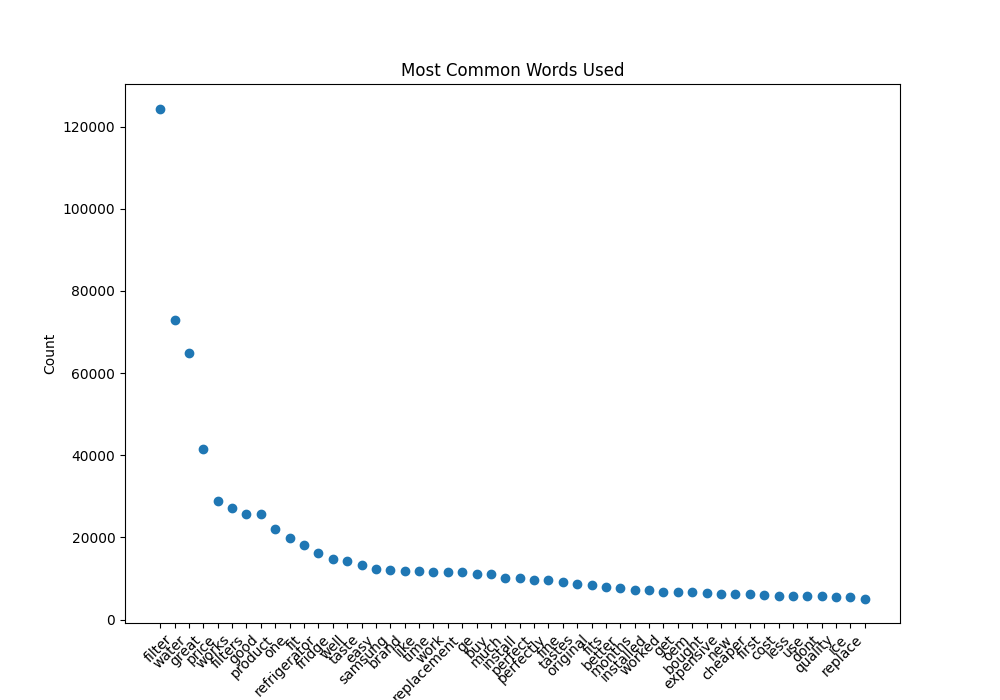

In [ ]:
# Since the scatter visual is too compacted, we will narrow it down to the top 50 words used in the dataset. 
# We will probably see that a great handful of words consist of "water" and "filter" and remove them as outliers

plt.clf()

n_top = 50
top_words = count_df.sort('count', ascending = False).limit(n_top).toPandas()

plt.scatter(top_words['word'], top_words['count'])
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Common Words Used')

%matplot plt

# Outliers

In [ ]:
# Since the dataset is already categorized as Water Filters, the words "water" and "filter" are given in the descriptions and occur too frequently

no_outliers = imputed[imputed.FuelEconomy < 40]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'imputed' is not defined
Traceback (most recent call last):
NameError: name 'imputed' is not defined



In [ ]:
descriptive_stats = no_outliers.describe()
descriptive_stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'no_outliers' is not defined
Traceback (most recent call last):
NameError: name 'no_outliers' is not defined



# Removal of Outliers Visuals

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

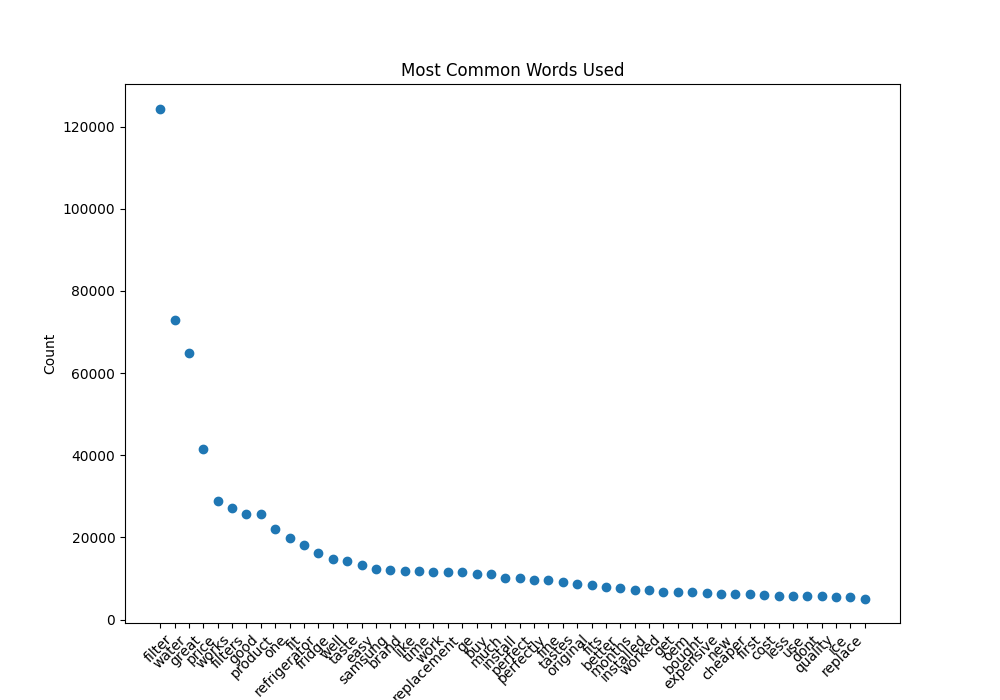

In [ ]:
# Re-create the scatter plot of the top 50 words to see that "water" and "filter" are now removed

plt.clf()

n_top = 50
top_words = count_df.sort('count', ascending = False).limit(n_top).toPandas()

plt.scatter(top_words['word'], top_words['count'])
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Common Words Used')

%matplot plt

# Project Milestone 3: Modeling

# Logistic Regression

In [ ]:
import pyspark.ml.stat as st
import pyspark.ml.feature as feat
import pyspark.sql.functions as F
from pyspark.ml import *
from pyspark.ml.feature import *
from pyspark.ml.stat import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
corrr_matrix = df_final.corr()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
corr() missing 2 required positional arguments: 'col1' and 'col2'
Traceback (most recent call last):
TypeError: corr() missing 2 required positional arguments: 'col1' and 'col2'



In [ ]:
df_review = df_final.select('reviews', col('rating').cast('Int'))
df_review.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|             reviews|rating|
+--------------------+------+
|great price commo...|     5|
|easy install appe...|     5|
|two days ordered ...|     5|
|great product fas...|     5|
|second purchase p...|     1|
|    exactly expected|     5|
|purchased product...|     5|
|fits like origina...|     4|
|convenient  bette...|     5|
|third order filte...|     4|
|third order filte...|     5|
|third order filte...|     5|
|filter want top s...|     1|
|product arrived t...|     5|
|good price fast d...|     5|
|product described...|     5|
|filter chlorine t...|     1|
|works well good p...|     5|
|works well good p...|     5|
|bought replacemen...|     5|
+--------------------+------+
only showing top 20 rows

In [ ]:
#Train test data according to 75-25 rule

test_train_data = df_review.randomSplit([0.75, 0.25], seed = 6666)

train_data = test_train_data[0]
test_data = test_train_data[1]

print('Train:', train_data.count(), '\nTest:', test_data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train: 109054 
Test: 36258

In [ ]:
# Tokenize the text

tokenizer = Tokenizer(inputCol = "reviews", outputCol = "sentiment")
tokenizedTrain = tokenizer.transform(train_data)
tokenizedTrain.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|             reviews|rating|           sentiment|
+--------------------+------+--------------------+
|                    |     4|                  []|
|                    |     4|                  []|
|                    |     5|                  []|
|                    |     5|                  []|
|                    |     5|                  []|
|                    |     5|                  []|
|                    |     5|                  []|
|                    |     5|                  []|
|  days water tast...|     1|[, , days, water,...|
| bought   month a...|     1|[, bought, , , mo...|
| bought new lg re...|     5|[, bought, new, l...|
| boxes opened  su...|     1|[, boxes, opened,...|
| cents time reord...|     3|[, cents, time, r...|
| concerns  handle...|     1|[, concerns, , ha...|
| days started lea...|     1|[, days, started,...|
| filter cheapest ...|     5|[, filter, cheape...|
| filters less pri...|     5|[,

In [ ]:
# See that there are some null values, remove them

tokenizedTrain = tokenizedTrain.na.drop()
tokenizedTrain = tokenizedTrain.dropDuplicates()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Convert the words into feature vectors

hashing_tf = HashingTF(inputCol = "sentiment", outputCol = "features")
hashed_td = hashing_tf.transform(tokenizedTrain)
hashed_td.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+--------------------+
|             reviews|rating|           sentiment|            features|
+--------------------+------+--------------------+--------------------+
|best flow filter ...|     5|[best, flow, filt...|(262144,[67117,10...|
|                 buy|     5|               [buy]|(262144,[213760],...|
|comparable  learn...|     1|[comparable, , le...|(262144,[11941,31...|
|far filter works ...|     4|[far, filter, wor...|(262144,[107201,1...|
|filter leaked eve...|     1|[filter, leaked, ...|(262144,[18176,21...|
|great item  fast ...|     5|[great, item, , f...|(262144,[113503,1...|
|great replacement...|     5|[great, replaceme...|(262144,[26143,52...|
|item arrived time...|     5|[item, arrived, t...|(262144,[77073,12...|
|little leaking wa...|     3|[little, leaking,...|(262144,[3834,671...|
|works good name b...|     5|[works, good, nam...|(262144,[3834,351...|
|correct fit works...|     5|[correct, fit, wo...|(262144,[2325,

In [ ]:
# Unable to proceed unless "sentiment" column is a string

hashed_td = hashed_td.withColumn("sentiment", col("sentiment").cast("string"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
lr = LogisticRegression(labelCol = "rating", featuresCol = "features", 
                        maxIter = 10, regParam = 0.01)
model = lr.fit(hashed_td)
print ("Training Done")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training Done

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# split into train and test sets
forest_train, forest_test = (
    forest_df
    .randomSplit([0.7, 0.3], seed=666)
)

# create string indexer for categorical columns
indexer = StringIndexer(inputCols=["col1", "col2"], outputCols=["col1_indexed", "col2_indexed"])

# create one-hot encoder for categorical columns
encoder = OneHotEncoder(inputCols=["col1_indexed", "col2_indexed"], outputCols=["col1_encoded", "col2_encoded"])

# convert all features to vector except for last column
vectorAssembler = VectorAssembler(inputCols=[x for x in forest_train.columns if x != 'CoverType'], outputCol='features')

# select top 10 predictors
selector = ChiSqSelector(numTopFeatures=10, outputCol="selectedFeatures", labelCol="CoverType", featuresCol="features")

# create logistic regression object
# DV has 7 classes
logReg_obj = LogisticRegression(labelCol='CoverType', featuresCol='selectedFeatures', regParam=0.01, elasticNetParam=1.0, family='multinomial')

# create random forest object
rf_obj = RandomForestClassifier(labelCol='CoverType', featuresCol='features', numTrees=10, seed=666)

# create pipeline of 1) string indexer, 2) one-hot encoder, 3) vector, 4) chisquare selector, 5) logistic regression
pipeline_logReg = Pipeline(stages=[indexer, encoder, vectorAssembler, selector, logReg_obj])

# create pipeline of 1) vector, 2) random forest
pipeline_rf = Pipeline(stages=[vectorAssembler, rf_obj])

# train the models
logReg_model = pipeline_logReg.fit(forest_train)
rf_model = pipeline_rf.fit(forest_train)

# make predictions on test data
logReg_predictions = logReg_model.transform(forest_test)
rf_predictions = rf_model.transform(forest_test)

# evaluate the models
logReg_evaluator = MulticlassClassificationEvaluator(labelCol="CoverType", predictionCol="prediction", metricName="accuracy")
rf_evaluator = MulticlassClassificationEvaluator(labelCol="CoverType", predictionCol="prediction", metricName="accuracy")

logReg_accuracy = logReg_evaluator.evaluate(logReg_predictions)
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

# print the accuracies
print("Logistic Regression accuracy:", logReg_accuracy)
print("Random Forest accuracy:", rf_accuracy)

# use ParamGridBuilder to build a grid of parameters
logReg_paramGrid = (ParamGridBuilder()
                   # try 4 values for regParam
                   .addGrid(logReg_obj.regParam, [0.0, 0.01, 0.02])
                   # try 4 values for elasticNetParam
                   .addGrid(logReg_obj.elasticNetParam, [0


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
unexpected EOF while parsing (<stdin>, line 62)
  File "<stdin>", line 62
    .addGrid(logReg_obj.elasticNetParam, [0
                                          ^
SyntaxError: unexpected EOF while parsing



In [ ]:

# Convert all features to vector except for sentiment column
vector_assembler = feat.VectorAssembler(
    inputCols=[c for c in model.columns if c != 'sentiment'],
    outputCol='features'
)

# Select top 10 predictors
selector = feat.UnivariateFeatureSelector(
    labelCol='sentiment',
    outputCol='selected',
    selectionMode='numTopFeatures'
).setFeatureType("categorical"
).setLabelType("categorical"
).setSelectionThreshold(10) # Select top 10 features

# Create a logistic regression object
log_reg = cl.LogisticRegression(
    labelCol='sentiment',
    featuresCol=selector.getOutputCol(),
    regParam=0.01,
    elasticNetParam=1.0,
    family='binomial' # Use binomial family for binary classification
)

# Create pipeline of 1) vector, 2) chi-square selector, 3) logistic regression
pipeline = Pipeline(
    stages=[
        vector_assembler,
        selector,
        log_reg
    ]
)

# Train the model
model = pipeline.fit(train_data)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
'LogisticRegressionModel' object has no attribute 'columns'
Traceback (most recent call last):
AttributeError: 'LogisticRegressionModel' object has no attribute 'columns'



In [ ]:
# Define LabelIndexer
label_idx = StringIndexer(inputCol = 'sentiment', outputCol = 'sentiment_class')
indexed_td = label_idx.fit(hashed_td).transform(hashed_td)


# Define VectorAssembler
va = VectorAssembler(inputCols = ['features'], outputCol = 'features_vector')
ass_td = va.transform(indexed_td)

# Create logistics regression for classification
lr = LogisticRegression(featuresCol = 'features_vector', labelCol = 'sentiment_class')
lr_model = lr.fit(ass_td)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
An error occurred while calling o6501.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 841.0 failed 4 times, most recent failure: Lost task 1.3 in stage 841.0 (TID 6542) (ip-172-31-87-133.ec2.internal executor 7): org.apache.spark.SparkException: Failed to execute user defined function (StringIndexerModel$$Lambda$6058/444397385: (string) => double)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:177)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage14.hashAgg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage14.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(Buf

In [ ]:

# Define evaluator for classification
evaluator = MulticlassClassificationEvaluator(
    labelCol = 'sentiment_class',
    predictionCol = 'prediction',
    metricName = 'accuracy'
)

In [ ]:
#Create a pipeline

pipeline = Pipeline(stages = [tokenizer, hashing_tf, label_idx, va, lr])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'va' is not defined
Traceback (most recent call last):
NameError: name 'va' is not defined



In [ ]:
# Use ParamGridBuilder to build a grid of parameters

param_grid = (
    ParamGridBuilder()
    # Test 4 values for regParam
    .addGrid(lr.regParam, [0.0, 0.01, 0.02])
    # Test 4 values for elasticNetParam
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'lr' is not defined
Traceback (most recent call last):
NameError: name 'lr' is not defined



In [ ]:
# CrossValidator will search over the parameter grid made and determine the best model

cv = CrossValidator(
    estimator = pipeline,
    estimatorParamMaps = param_grid,
    evaluator = evaluator,
    numFolds = 10
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'pipeline' is not defined
Traceback (most recent call last):
NameError: name 'pipeline' is not defined



In [ ]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="reviewText", outputCol="sentiment")

# Convert the words into feature vectors
hashing_tf = HashingTF(inputCol="sentiment", outputCol="features")

# Define LabelIndexer
label_idx = StringIndexer(inputCol='overall', outputCol='label')

# Define VectorAssembler
assembler = VectorAssembler(inputCols=['features'], outputCol='features_vec')

# Create a logistic regression model
lr = LogisticRegression(featuresCol='features_vec', labelCol='label')

# Define evaluator for classification
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, hashing_tf, label_idx, assembler, lr])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['reviews', 'rating']

In [ ]:
# Fit the model

cv_model = cv.fit(train_data)
pred = cv_model.transform(test_data)
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'cv' is not defined
Traceback (most recent call last):
NameError: name 'cv' is not defined



In [ ]:
numericTrain = hashTF.transform(df_final)
numericTrain.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'hashTF' is not defined
Traceback (most recent call last):
NameError: name 'hashTF' is not defined



In [ ]:
#logestic regression -- need to fine tune hyperparam as required
lr = LogisticRegression(labelCol="rating", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrain)
print ("Training Done")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'numericTrain' is not defined
Traceback (most recent call last):
NameError: name 'numericTrain' is not defined



# Random Forest 

In [ ]:
import pyspark.ml.tuning as tune
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as ev


vectorAssembler = feat.VectorAssembler(
    inputCols=["features"]
    , outputCol='feature_vector')

rf_obj = cl.RandomForestClassifier(
    labelCol='label'
    , featuresCol='feature_vector'
)

#use ParamGridBuilder to build a grid of parameters
rf_grid = (
    tune.ParamGridBuilder()
    #try 3 values for numTrees
    .addGrid(rf_obj.numTrees
            , [5, 10, 15]
        )
    #try 3 values for maxDepth
    .addGrid(rf_obj.maxDepth
            , [5, 10, 15]
        )
    .build()
)

rf_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
        , labelCol='label')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=rf_obj
    , estimatorParamMaps=rf_grid
    , evaluator=rf_ev
)

pipeline = Pipeline(stages=[vectorAssembler])
data_trans = pipeline.fit(df_review)

rf_modelTest = cross_v.fit(
    data_trans.transform(df_review)
)

print('Best params - numTrees: {}, maxDepth: {}'.format(
    rf_modelTest.bestModel._java_obj.getNumTrees(),
      rf_modelTest.bestModel._java_obj.getMaxDepth()))

import pandas as pd
tuning_results = pd.DataFrame([list(x.values()) for x in rf_grid], columns=['numTrees', 'maxDepth'])
tuning_results['F-1'] = rf_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
features does not exist. Available: reviews, rating
Traceback (most recent call last):
  File "/mnt1/yarn/usercache/livy/appcache/application_1683768549765_0001/container_1683768549765_0001_01_000001/pyspark.zip/pyspark/ml/base.py", line 262, in transform
    return self._transform(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1683768549765_0001/container_1683768549765_0001_01_000001/pyspark.zip/pyspark/ml/pipeline.py", line 304, in _transform
    dataset = t.transform(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1683768549765_0001/container_1683768549765_0001_01_000001/pyspark.zip/pyspark/ml/base.py", line 262, in transform
    return self._transform(dataset)
  File "/mnt1/yarn/usercache/livy/appcache/application_1683768549765_0001/container_1683768549765_0001_01_000001/pyspark.zip/pyspark/ml/wrapper.py", line 396, in _transform
    return DataFrame(self._java_obj.transform(dataset._jdf), dataset.sparkSession)
  File "/mnt